### Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob

#PCA Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For Machine Learning Section
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# For dealing with dataset imbalance
from imblearn.over_sampling import SMOTE

# For XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# For hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

C:\Users\10011881\.julia\conda\3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Getting the multiple csv files into a dataframe

In [2]:
path = '' # use your path
all_files = glob.glob(path + "/*.csv")

collector = []

for filename in all_files:
    safety = pd.read_csv(filename, index_col=None, header=0)
    collector.append(safety)

xdf = pd.concat(collector, axis=0, ignore_index=True)

### Checking the labelled data
This is to see the balance of the categories

In [3]:
labels = pd.read_csv('~/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')
labels.groupby('label').count()

,bookingID
label,
0,15017
1,5001


### Feature Extraction

In [4]:
#GPS Accuracy
accuracy = xdf[['bookingID','Accuracy']].groupby('bookingID').agg(['min','max','mean','std'])

#GPS Bearing
bearing = xdf[['bookingID','Bearing']].groupby('bookingID').agg(['min','max','mean','std'])

# XYZ-axis acceleration
acc_x = xdf[['bookingID','acceleration_x']].groupby('bookingID').agg(['min','max','mean','std'])
acc_y = xdf[['bookingID','acceleration_y']].groupby('bookingID').agg(['min','max','mean','std'])
acc_z = xdf[['bookingID','acceleration_z']].groupby('bookingID').agg(['min','max','mean','std'])

# Roll, pitch, yaw
gyr_x = xdf[['bookingID','gyro_x']].groupby('bookingID').agg(['min','max','mean','std'])
gyr_y = xdf[['bookingID','gyro_y']].groupby('bookingID').agg(['min','max','mean','std'])
gyr_z = xdf[['bookingID','gyro_z']].groupby('bookingID').agg(['min','max','mean','std'])

# Time elapsed
sec = xdf[['bookingID','second']].groupby('bookingID').agg(['min','max','mean', 'std'])

# Speed
spd = xdf[['bookingID','Speed']].groupby('bookingID').agg(['min','max','mean', 'std'])

### Merging the extracted features

In [5]:
# First merge accuracy + bearing
df_merged = pd.merge(accuracy,bearing,how='inner',on='bookingID')

# + acc_xyz
df_merged = pd.merge(df_merged,acc_x,how='inner',on='bookingID')
df_merged = pd.merge(df_merged,acc_y,how='inner',on='bookingID')
df_merged = pd.merge(df_merged,acc_z,how='inner',on='bookingID')

# + gyro_xyz
df_merged = pd.merge(df_merged,gyr_x,how='inner',on='bookingID')
df_merged = pd.merge(df_merged,gyr_y,how='inner',on='bookingID')
df_merged = pd.merge(df_merged,gyr_z,how='inner',on='bookingID')

# +sec and spd
df_merged = pd.merge(df_merged,sec,how='inner',on='bookingID')
df_merged = pd.merge(df_merged,spd,how='inner',on='bookingID')

df_merged.head()

Accuracy                                Bearing              \
               min     max       mean       std       min         max   
bookingID                                                               
0              4.0  48.000  10.165339  3.855898  0.037464  359.979767   
1              3.0   7.709   3.718763  0.597933  0.000000  337.000000   
2              3.0   8.000   3.930626  1.117354  1.000000  354.000000   
4             10.0  10.000  10.000000  0.000000  2.271227  353.855377   
6              3.0  12.000   4.586721  1.329545  0.000000  359.000000   

                                  acceleration_x            ...    gyro_z  \
                 mean         std            min       max  ...      mean   
bookingID                                                   ...             
0          176.526099  129.231351      -4.692294  4.782614  ... -0.004188   
1          124.198590   89.861236      -5.352994  3.813341  ...  0.000405   
2          173.794872  119.316520      -2.971295  1.956122  ...  0.002597   
4          151.807013   71.273774      -2.866458  2.019635  ... -0.000376   
6          197.812785  111.868249      -4.352792  5.593026  ...  0.002930   

                    second                                 Speed             \
                std    min     max        mean         std   min        max   
bookingID                                                                     
0          0.063685    0.0  1589.0  903.526892  533.745097  -1.0  22.946083   
1          0.033838    0.0  1034.0  581.175088  289.339367  -1.0  21.882141   
2          0.036215    0.0   825.0  339.441026  356.319445   0.0   9.360483   
4          0.065927    0.0  1094.0  547.495430  315.962793   0.0  19.780001   
6          0.057438    0.0  1094.0  547.000000  316.243577   0.0  16.394695   

                               
               mean       std  
bookingID                      
0          8.994822  7.199919  
1          7.881588  7.059362  
2          3.157213  2.897762  
4          6.150996  5.595901  
6          4.628921  5.314844  

[5 rows x 40 columns]

### Flattening the Hierarchical Columns

In [6]:
headers = df_merged.columns
x = pd.Index([e[0] + e[1] for e in headers.tolist()])
df_merged.columns = x
df_merged.head()

,Accuracymin,Accuracymax,Accuracymean,Accuracystd,Bearingmin,Bearingmax,Bearingmean,Bearingstd,acceleration_xmin,acceleration_xmax,...,gyro_zmean,gyro_zstd,secondmin,secondmax,secondmean,secondstd,Speedmin,Speedmax,Speedmean,Speedstd
bookingID,,,,,,,,,,,,,,,,,,,,,
0,4.0,48.000,10.165339,3.855898,0.037464,359.979767,176.526099,129.231351,-4.692294,4.782614,...,-0.004188,0.063685,0.0,1589.0,903.526892,533.745097,-1.0,22.946083,8.994822,7.199919
1,3.0,7.709,3.718763,0.597933,0.000000,337.000000,124.198590,89.861236,-5.352994,3.813341,...,0.000405,0.033838,0.0,1034.0,581.175088,289.339367,-1.0,21.882141,7.881588,7.059362
2,3.0,8.000,3.930626,1.117354,1.000000,354.000000,173.794872,119.316520,-2.971295,1.956122,...,0.002597,0.036215,0.0,825.0,339.441026,356.319445,0.0,9.360483,3.157213,2.897762
4,10.0,10.000,10.000000,0.000000,2.271227,353.855377,151.807013,71.273774,-2.866458,2.019635,...,-0.000376,0.065927,0.0,1094.0,547.495430,315.962793,0.0,19.780001,6.150996,5.595901
6,3.0,12.000,4.586721,1.329545,0.000000,359.000000,197.812785,111.868249,-4.352792,5.593026,...,0.002930,0.057438,0.0,1094.0,547.000000,316.243577,0.0,16.394695,4.628921,5.314844


### Adding in the records count per trip
It was observed that trips tagged as dangerous/`1` has more record counts than the safe/`0` one

In [7]:
rec_count = xdf['bookingID'].value_counts()
rec_count = pd.DataFrame({'bookingID':rec_count.index, 'records':rec_count.values})
df_merged = pd.merge(rec_count,df_merged,how='inner',on='bookingID')

### Putting in the Labels ready for PCA 

In [8]:
df_pca = pd.merge(labels,df_merged,how='inner',on='bookingID')
df_pca.head()

,bookingID,label,records,Accuracymin,Accuracymax,Accuracymean,Accuracystd,Bearingmin,Bearingmax,Bearingmean,...,gyro_zmean,gyro_zstd,secondmin,secondmax,secondmean,secondstd,Speedmin,Speedmax,Speedmean,Speedstd
0,111669149733,0,765,3.0,16.000,4.113565,1.469971,0.0,359.0,171.860131,...,0.001209,0.029111,0.0,764.0,382.000000,220.980768,0.0,19.630571,5.221818,5.683601
1,335007449205,1,1050,3.0,16.000,4.107847,1.316996,0.0,359.0,226.050476,...,-0.002869,0.028351,0.0,1049.0,524.500000,303.253195,-1.0,19.367985,6.029687,6.092663
2,171798691856,0,423,3.9,1299.999,19.141586,108.415683,0.0,358.0,41.356974,...,-0.031219,0.045928,0.0,939.0,724.659574,133.898764,-1.0,26.500000,16.419031,7.782730
3,1520418422900,0,931,3.0,8.576,3.793319,0.624812,0.0,358.0,204.508056,...,0.000776,0.121698,0.0,944.0,471.481203,273.821020,-1.0,24.850000,13.459441,8.436861
4,798863917116,0,555,3.0,8.000,3.891488,0.877804,169.0,300.0,218.437838,...,-0.000900,0.026289,0.0,554.0,277.000000,160.358972,0.0,21.993572,8.729576,6.829455


In [9]:
df_pca.columns

Index(['bookingID', 'label', 'records', 'Accuracymin', 'Accuracymax',
       'Accuracymean', 'Accuracystd', 'Bearingmin', 'Bearingmax',
       'Bearingmean', 'Bearingstd', 'acceleration_xmin', 'acceleration_xmax',
       'acceleration_xmean', 'acceleration_xstd', 'acceleration_ymin',
       'acceleration_ymax', 'acceleration_ymean', 'acceleration_ystd',
       'acceleration_zmin', 'acceleration_zmax', 'acceleration_zmean',
       'acceleration_zstd', 'gyro_xmin', 'gyro_xmax', 'gyro_xmean',
       'gyro_xstd', 'gyro_ymin', 'gyro_ymax', 'gyro_ymean', 'gyro_ystd',
       'gyro_zmin', 'gyro_zmax', 'gyro_zmean', 'gyro_zstd', 'secondmin',
       'secondmax', 'secondmean', 'secondstd', 'Speedmin', 'Speedmax',
       'Speedmean', 'Speedstd'],
      dtype='object')

### Scaling the Data

In [10]:
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)

In [11]:
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### PCA Transformations

In [12]:
x_pca = pca.transform(scaled_data)
scaled_data.shape

(20018, 43)

In [13]:
x_pca.shape

(20018, 2)

### Plotting the First and Second Principal Components

Text(0, 0.5, '2nd Principal Component')

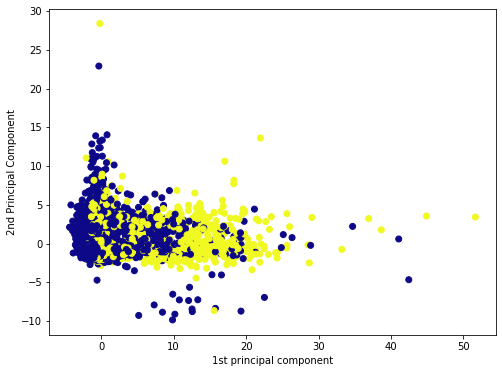

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df_pca['label'],cmap='plasma')
plt.xlabel('1st principal component')
plt.ylabel('2nd Principal Component')

### Viewing the Heatmap for Correlation

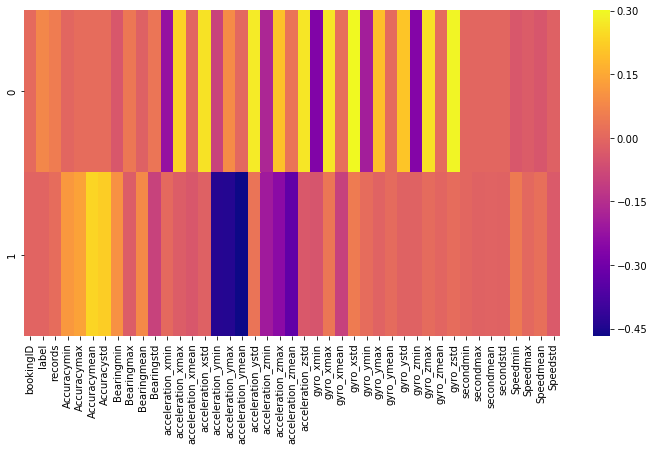

In [15]:
df_comp = pd.DataFrame(pca.components_,columns=df_pca.columns)
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

**Note:** *"It appears that trips involving dangerous driving has strong association with large variations in the GPS accuracy metric. These are probably areas/occassions where a driver can't get a proper GPS fix and has to tinker with the mobile phone - a distraction that keeps his hands off the wheel and his eyes off the road."*  
**Recommendation:** **1)** Drivers have to observe proper installation of mobile phones near the car dashboard to get optimum gps signal strength  
**2)** Encourage screen mirroring or casting on cars with capable built-in displays to minimize distractions  
**3)** Identify locations usually encountered in cities with high buildings, to properly warn drivers of the gps fix delays  
**4)** Install in-car GPS signal boosters

## Machine Learning Phase
Preparing the data

In [16]:
df = df_pca

In [17]:
filter = list(df.columns)
filter.remove('bookingID')
filter.remove('label')
X = df[filter]
y = df['label']

### Creating Train-Test Split

In [18]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
classifier = XGBClassifier()
trained_model = classifier.fit(X_train, y_train)
pred1 = trained_model.predict(X_test)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3024
           1       0.69      0.19      0.30       980

    accuracy                           0.78      4004
   macro avg       0.74      0.58      0.58      4004
weighted avg       0.76      0.78      0.73      4004



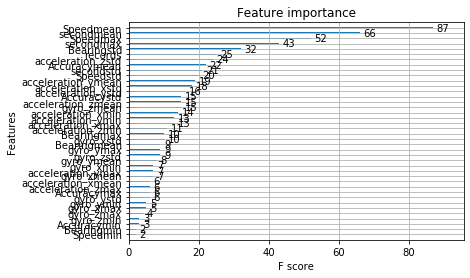

In [20]:
xgb.plot_importance(trained_model)
plt.rcParams['figure.figsize'] = [60,60]
plt.show()

### Applying SMOTE
Checking the `ytrain` value counts. It could be noted that the data is highly imbalanced  
resulting to low recall performance

In [21]:
y_train.value_counts()

0    11993
1     4021
Name: label, dtype: int64

In [22]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

### Checking the balance in the categories

In [23]:
np.bincount(y_train)

array([11993, 11993], dtype=int64)

In [24]:
#Appending columns and converting to dataframe
X_train = pd.DataFrame(X_train, columns=X_test.columns)

### Training XGBoost Classifier

In [25]:
classifier_smote = XGBClassifier()
trained_model_smote = classifier_smote.fit(X_train, y_train)
pred_smote = trained_model_smote.predict(X_test)
print(classification_report(y_test, pred_smote))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3024
           1       0.46      0.42      0.44       980

    accuracy                           0.74      4004
   macro avg       0.64      0.63      0.63      4004
weighted avg       0.73      0.74      0.73      4004



**Note:** Applying SMOTE has improved recall which supports the models sensitivity to the occurrences of dangerous driving

### Viewing Feature Importance

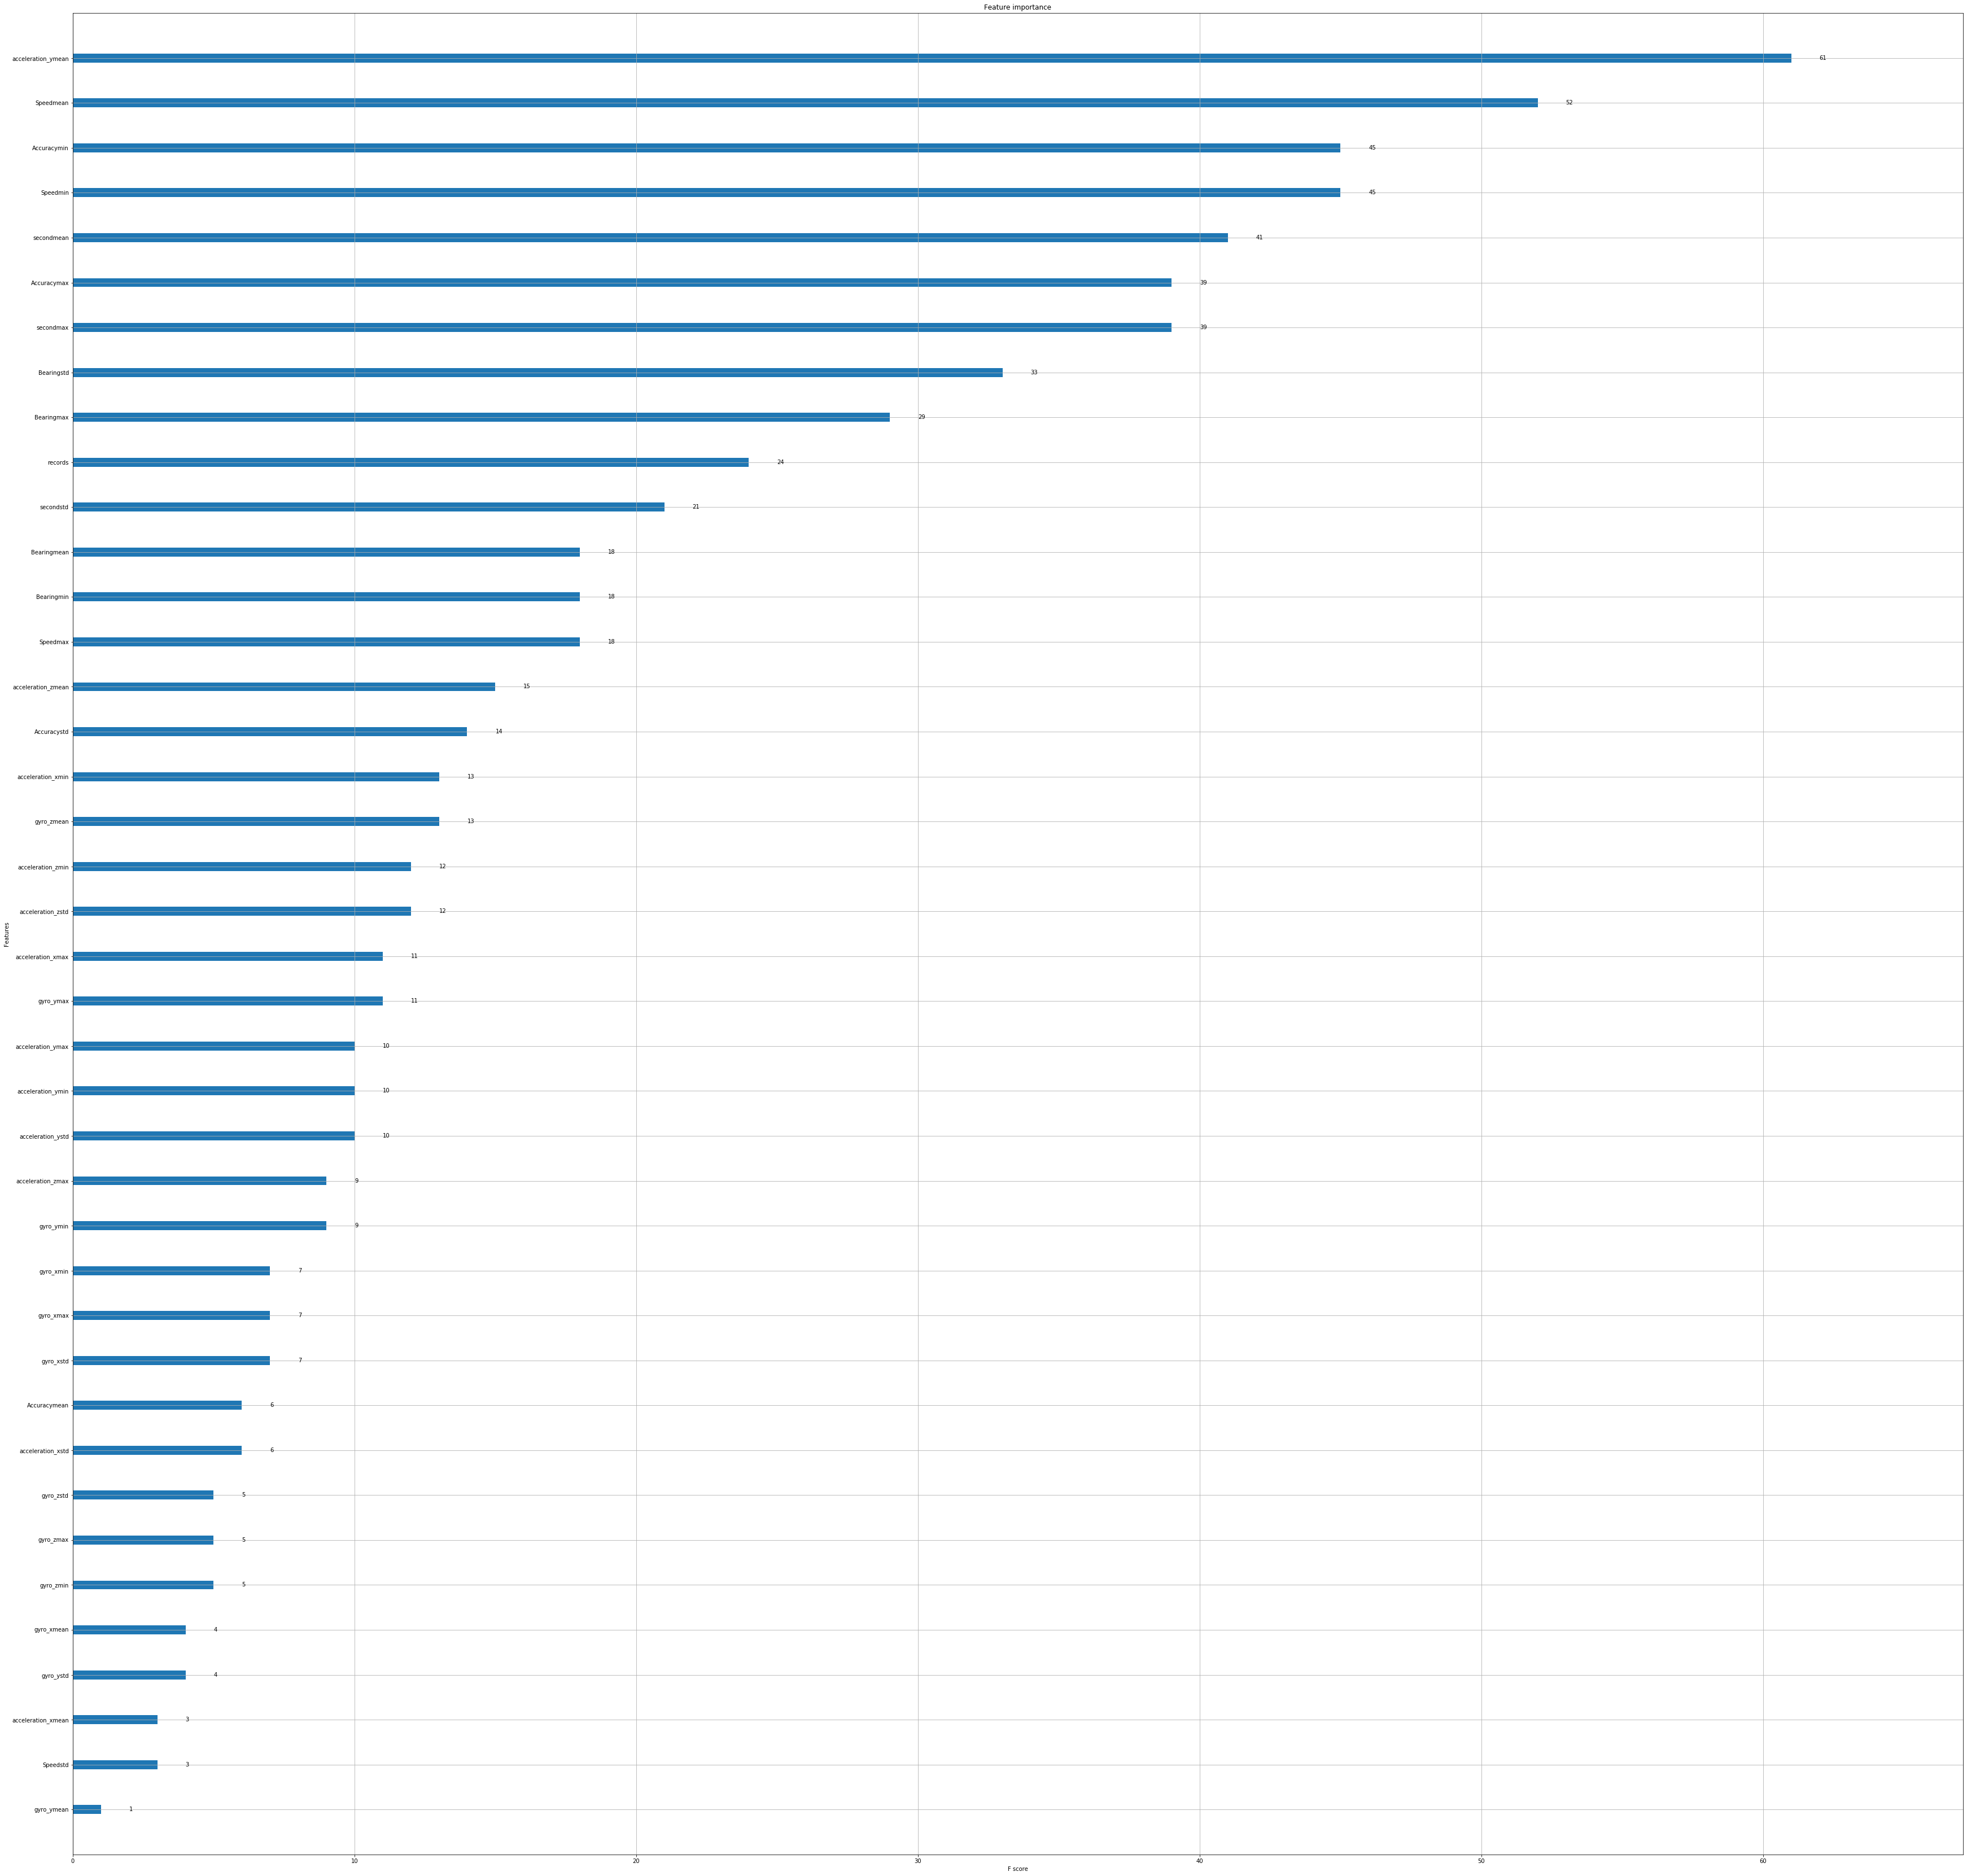

In [26]:
xgb.plot_importance(trained_model_smote)
plt.rcParams['figure.figsize'] = [60,60]
plt.show()

**Note:** Now with SMOTE it can be seen that `acceleration_ymean` figures in at the top of the features and also the time metrics `secondmean` (not seen in PCA), which makes sense since large changes in the car speed over time also is perceived by passengers - both for the sudden stops and speed ups

### Model Performance Evaluation using AUC-ROC

In [27]:
probs = trained_model_smote.predict_proba(X_test)

In [28]:
probs = probs[:, 1]

In [29]:
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.712


### Hyper parameter Tuning
Settings for the base model

In [30]:
model = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=105)

In [31]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.791267	validation_0-error:0.285583	validation_1-auc:0.690533	validation_1-error:0.288212
[1]	validation_0-auc:0.803878	validation_0-error:0.278996	validation_1-auc:0.702259	validation_1-error:0.267483
[2]	validation_0-auc:0.805747	validation_0-error:0.277745	validation_1-auc:0.699862	validation_1-error:0.275225
[3]	validation_0-auc:0.80803	validation_0-error:0.277704	validation_1-auc:0.704132	validation_1-error:0.276723
[4]	validation_0-auc:0.809889	validation_0-error:0.274952	validation_1-auc:0.708447	validation_1-error:0.271479
[5]	validation_0-auc:0.815329	validation_0-error:0.273076	validation_1-auc:0.712124	validation_1-error:0.272977
[6]	validation_0-auc:0.8152	validation_0-error:0.272242	validation_1-auc:0.711401	validation_1-error:0.271728
[7]	validation_0-auc:0.81603	validation_0-error:0.274035	validation_1-auc:0.712222	validation_1-error:0.271479
[8]	validation_0-auc:0.815969	validation_0-error:0.271909	validation_1-auc:0.71312	validation_1-error:0.2727

[73]	validation_0-auc:0.834054	validation_0-error:0.266405	validation_1-auc:0.718779	validation_1-error:0.266733
[74]	validation_0-auc:0.834124	validation_0-error:0.266572	validation_1-auc:0.718532	validation_1-error:0.265984
[75]	validation_0-auc:0.834124	validation_0-error:0.26653	validation_1-auc:0.718369	validation_1-error:0.265984
[76]	validation_0-auc:0.834572	validation_0-error:0.265822	validation_1-auc:0.718463	validation_1-error:0.265734
[77]	validation_0-auc:0.83462	validation_0-error:0.265822	validation_1-auc:0.718506	validation_1-error:0.265984
[78]	validation_0-auc:0.834977	validation_0-error:0.265447	validation_1-auc:0.718408	validation_1-error:0.265485
[79]	validation_0-auc:0.835221	validation_0-error:0.264863	validation_1-auc:0.718509	validation_1-error:0.265485
[80]	validation_0-auc:0.835257	validation_0-error:0.265113	validation_1-auc:0.718604	validation_1-error:0.265734
[81]	validation_0-auc:0.835259	validation_0-error:0.265113	validation_1-auc:0.718414	validation_1-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=105, silent=True,
              subsample=0.8)

In [32]:
pred2 = model.predict(X_test)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3024
           1       0.46      0.47      0.47       980

    accuracy                           0.74      4004
   macro avg       0.65      0.65      0.65      4004
weighted avg       0.74      0.74      0.74      4004



In [33]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]

In [34]:
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.720


### Using grid search to find the optimum `n_estimators`

In [35]:
param_test1 = {'n_estimators':[100,150,200,300,400]}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.01, n_estimators=100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=105), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

model2 = gsearch1.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.791267	validation_0-error:0.285583	validation_1-auc:0.690533	validation_1-error:0.288212
[1]	validation_0-auc:0.803878	validation_0-error:0.278996	validation_1-auc:0.702259	validation_1-error:0.267483
[2]	validation_0-auc:0.805747	validation_0-error:0.277745	validation_1-auc:0.699862	validation_1-error:0.275225
[3]	validation_0-auc:0.80803	validation_0-error:0.277704	validation_1-auc:0.704132	validation_1-error:0.276723
[4]	validation_0-auc:0.809889	validation_0-error:0.274952	validation_1-auc:0.708447	validation_1-error:0.271479
[5]	validation_0-auc:0.815329	validation_0-error:0.273076	validation_1-auc:0.712124	validation_1-error:0.272977
[6]	validation_0-auc:0.8152	validation_0-error:0.272242	validation_1-auc:0.711401	validation_1-error:0.271728
[7]	validation_0-auc:0.81603	validation_0-error:0.274035	validation_1-auc:0.712222	validation_1-error:0.271479
[8]	validation_0-auc:0.815969	validation_0-error:0.271909	validation_1-auc:0.71312	validation_1-error:0.2727

[73]	validation_0-auc:0.834054	validation_0-error:0.266405	validation_1-auc:0.718779	validation_1-error:0.266733
[74]	validation_0-auc:0.834124	validation_0-error:0.266572	validation_1-auc:0.718532	validation_1-error:0.265984
[75]	validation_0-auc:0.834124	validation_0-error:0.26653	validation_1-auc:0.718369	validation_1-error:0.265984
[76]	validation_0-auc:0.834572	validation_0-error:0.265822	validation_1-auc:0.718463	validation_1-error:0.265734
[77]	validation_0-auc:0.83462	validation_0-error:0.265822	validation_1-auc:0.718506	validation_1-error:0.265984
[78]	validation_0-auc:0.834977	validation_0-error:0.265447	validation_1-auc:0.718408	validation_1-error:0.265485
[79]	validation_0-auc:0.835221	validation_0-error:0.264863	validation_1-auc:0.718509	validation_1-error:0.265485
[80]	validation_0-auc:0.835257	validation_0-error:0.265113	validation_1-auc:0.718604	validation_1-error:0.265734
[81]	validation_0-auc:0.835259	validation_0-error:0.265113	validation_1-auc:0.718414	validation_1-

[146]	validation_0-auc:0.850897	validation_0-error:0.24827	validation_1-auc:0.721503	validation_1-error:0.262488
[147]	validation_0-auc:0.85105	validation_0-error:0.247895	validation_1-auc:0.721703	validation_1-error:0.261738
[148]	validation_0-auc:0.851188	validation_0-error:0.247644	validation_1-auc:0.721501	validation_1-error:0.261738
[149]	validation_0-auc:0.851346	validation_0-error:0.247436	validation_1-auc:0.721624	validation_1-error:0.261239
[150]	validation_0-auc:0.851496	validation_0-error:0.247478	validation_1-auc:0.721621	validation_1-error:0.261239
[151]	validation_0-auc:0.851719	validation_0-error:0.247144	validation_1-auc:0.721764	validation_1-error:0.260739
[152]	validation_0-auc:0.851876	validation_0-error:0.246936	validation_1-auc:0.72179	validation_1-error:0.260739
[153]	validation_0-auc:0.852004	validation_0-error:0.246811	validation_1-auc:0.721783	validation_1-error:0.26049
[154]	validation_0-auc:0.852175	validation_0-error:0.246852	validation_1-auc:0.721692	valida

[219]	validation_0-auc:0.866694	validation_0-error:0.228717	validation_1-auc:0.721596	validation_1-error:0.254246
[220]	validation_0-auc:0.866822	validation_0-error:0.228425	validation_1-auc:0.721598	validation_1-error:0.254246
[221]	validation_0-auc:0.867104	validation_0-error:0.228383	validation_1-auc:0.721539	validation_1-error:0.254995
[222]	validation_0-auc:0.867217	validation_0-error:0.228133	validation_1-auc:0.721482	validation_1-error:0.254745
[223]	validation_0-auc:0.867321	validation_0-error:0.228216	validation_1-auc:0.721482	validation_1-error:0.255245
[224]	validation_0-auc:0.867485	validation_0-error:0.227966	validation_1-auc:0.721497	validation_1-error:0.254745
[225]	validation_0-auc:0.867677	validation_0-error:0.227758	validation_1-auc:0.72154	validation_1-error:0.254745
[226]	validation_0-auc:0.867806	validation_0-error:0.227633	validation_1-auc:0.721447	validation_1-error:0.254995
[227]	validation_0-auc:0.868029	validation_0-error:0.227174	validation_1-auc:0.721358	val

[292]	validation_0-auc:0.878993	validation_0-error:0.213958	validation_1-auc:0.721058	validation_1-error:0.254496
[293]	validation_0-auc:0.879112	validation_0-error:0.213958	validation_1-auc:0.721108	validation_1-error:0.253496
[294]	validation_0-auc:0.879258	validation_0-error:0.213666	validation_1-auc:0.721134	validation_1-error:0.254496
[295]	validation_0-auc:0.879417	validation_0-error:0.213333	validation_1-auc:0.72108	validation_1-error:0.254496
[296]	validation_0-auc:0.87951	validation_0-error:0.2135	validation_1-auc:0.721133	validation_1-error:0.254496
[297]	validation_0-auc:0.879573	validation_0-error:0.213333	validation_1-auc:0.721141	validation_1-error:0.254496
[298]	validation_0-auc:0.879663	validation_0-error:0.213291	validation_1-auc:0.721175	validation_1-error:0.253996
[299]	validation_0-auc:0.8798	validation_0-error:0.213291	validation_1-auc:0.721214	validation_1-error:0.253746
[300]	validation_0-auc:0.879901	validation_0-error:0.212874	validation_1-auc:0.721155	validati

[365]	validation_0-auc:0.887724	validation_0-error:0.204494	validation_1-auc:0.721137	validation_1-error:0.251498
[366]	validation_0-auc:0.887812	validation_0-error:0.204328	validation_1-auc:0.721213	validation_1-error:0.251748
[367]	validation_0-auc:0.887899	validation_0-error:0.204202	validation_1-auc:0.721223	validation_1-error:0.251748
[368]	validation_0-auc:0.887983	validation_0-error:0.204077	validation_1-auc:0.72124	validation_1-error:0.251998
[369]	validation_0-auc:0.888134	validation_0-error:0.204036	validation_1-auc:0.721378	validation_1-error:0.251249
[370]	validation_0-auc:0.888269	validation_0-error:0.204036	validation_1-auc:0.721351	validation_1-error:0.250999
[371]	validation_0-auc:0.888383	validation_0-error:0.203869	validation_1-auc:0.72141	validation_1-error:0.250999
[372]	validation_0-auc:0.888549	validation_0-error:0.203744	validation_1-auc:0.721314	validation_1-error:0.250749
[373]	validation_0-auc:0.88866	validation_0-error:0.20366	validation_1-auc:0.721288	valida

In [36]:
gsearch1.best_params_

{'n_estimators': 400}

Taking `n_estimators` at 400, I proceed to tune `max_depth` and `min_child_weight`

In [37]:
param_test2 = {
 'max_depth':[5,6,8,10],
 'min_child_weight':[1,2,3,4]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.01, n_estimators=400, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=105), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

model3 = gsearch2.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.872874	validation_0-error:0.21204	validation_1-auc:0.661168	validation_1-error:0.302947
[1]	validation_0-auc:0.89943	validation_0-error:0.18515	validation_1-auc:0.675988	validation_1-error:0.291708
[2]	validation_0-auc:0.909742	validation_0-error:0.177562	validation_1-auc:0.685332	validation_1-error:0.283966
[3]	validation_0-auc:0.915079	validation_0-error:0.172059	validation_1-auc:0.690552	validation_1-error:0.277223
[4]	validation_0-auc:0.920314	validation_0-error:0.165305	validation_1-auc:0.695599	validation_1-error:0.268731
[5]	validation_0-auc:0.926746	validation_0-error:0.158968	validation_1-auc:0.698559	validation_1-error:0.264985
[6]	validation_0-auc:0.9279	validation_0-error:0.157008	validation_1-auc:0.700424	validation_1-error:0.265485
[7]	validation_0-auc:0.929715	validation_0-error:0.155216	validation_1-auc:0.704865	validation_1-error:0.264985
[8]	validation_0-auc:0.931629	validation_0-error:0.154715	validation_1-auc:0.708703	validation_1-error:0.2619

[73]	validation_0-auc:0.957944	validation_0-error:0.122405	validation_1-auc:0.719015	validation_1-error:0.254496
[74]	validation_0-auc:0.958138	validation_0-error:0.122446	validation_1-auc:0.719001	validation_1-error:0.253996
[75]	validation_0-auc:0.958422	validation_0-error:0.121779	validation_1-auc:0.718914	validation_1-error:0.252997
[76]	validation_0-auc:0.958587	validation_0-error:0.121654	validation_1-auc:0.719283	validation_1-error:0.252248
[77]	validation_0-auc:0.958844	validation_0-error:0.121654	validation_1-auc:0.719219	validation_1-error:0.251748
[78]	validation_0-auc:0.959299	validation_0-error:0.120737	validation_1-auc:0.71895	validation_1-error:0.251249
[79]	validation_0-auc:0.959424	validation_0-error:0.12082	validation_1-auc:0.719035	validation_1-error:0.252497
[80]	validation_0-auc:0.959586	validation_0-error:0.120779	validation_1-auc:0.719022	validation_1-error:0.253247
[81]	validation_0-auc:0.95979	validation_0-error:0.120946	validation_1-auc:0.719053	validation_1-e

[146]	validation_0-auc:0.97237	validation_0-error:0.100934	validation_1-auc:0.719373	validation_1-error:0.248501
[147]	validation_0-auc:0.972491	validation_0-error:0.10085	validation_1-auc:0.71918	validation_1-error:0.248002
[148]	validation_0-auc:0.972683	validation_0-error:0.100434	validation_1-auc:0.719186	validation_1-error:0.248501
[149]	validation_0-auc:0.97277	validation_0-error:0.100475	validation_1-auc:0.719175	validation_1-error:0.248501
[150]	validation_0-auc:0.972969	validation_0-error:0.099808	validation_1-auc:0.719219	validation_1-error:0.248252
[151]	validation_0-auc:0.97309	validation_0-error:0.099516	validation_1-auc:0.719113	validation_1-error:0.247752
[152]	validation_0-auc:0.973287	validation_0-error:0.099141	validation_1-auc:0.718951	validation_1-error:0.248002
[153]	validation_0-auc:0.973447	validation_0-error:0.098974	validation_1-auc:0.718955	validation_1-error:0.248501
[154]	validation_0-auc:0.973719	validation_0-error:0.098307	validation_1-auc:0.719002	validat

[219]	validation_0-auc:0.982212	validation_0-error:0.084216	validation_1-auc:0.718394	validation_1-error:0.244006
[220]	validation_0-auc:0.982308	validation_0-error:0.083882	validation_1-auc:0.718415	validation_1-error:0.244256
[221]	validation_0-auc:0.982392	validation_0-error:0.08359	validation_1-auc:0.718504	validation_1-error:0.244505
[222]	validation_0-auc:0.982497	validation_0-error:0.083507	validation_1-auc:0.718318	validation_1-error:0.243756
[223]	validation_0-auc:0.982616	validation_0-error:0.083465	validation_1-auc:0.718393	validation_1-error:0.244006
[224]	validation_0-auc:0.982712	validation_0-error:0.083174	validation_1-auc:0.718319	validation_1-error:0.245005
[225]	validation_0-auc:0.982794	validation_0-error:0.083257	validation_1-auc:0.718391	validation_1-error:0.245255
[226]	validation_0-auc:0.982854	validation_0-error:0.08284	validation_1-auc:0.718348	validation_1-error:0.244755
[227]	validation_0-auc:0.982937	validation_0-error:0.082381	validation_1-auc:0.718414	vali

[292]	validation_0-auc:0.988816	validation_0-error:0.068457	validation_1-auc:0.718528	validation_1-error:0.242008
[293]	validation_0-auc:0.988881	validation_0-error:0.068248	validation_1-auc:0.718488	validation_1-error:0.242507
[294]	validation_0-auc:0.988958	validation_0-error:0.06804	validation_1-auc:0.718521	validation_1-error:0.241758
[295]	validation_0-auc:0.989064	validation_0-error:0.067915	validation_1-auc:0.718556	validation_1-error:0.242008
[296]	validation_0-auc:0.989153	validation_0-error:0.067915	validation_1-auc:0.718632	validation_1-error:0.242008
[297]	validation_0-auc:0.989211	validation_0-error:0.067456	validation_1-auc:0.718589	validation_1-error:0.241758
[298]	validation_0-auc:0.989251	validation_0-error:0.067414	validation_1-auc:0.718518	validation_1-error:0.241259
[299]	validation_0-auc:0.989322	validation_0-error:0.067373	validation_1-auc:0.718634	validation_1-error:0.241508
[300]	validation_0-auc:0.989381	validation_0-error:0.067331	validation_1-auc:0.718623	val

[365]	validation_0-auc:0.993035	validation_0-error:0.056533	validation_1-auc:0.718834	validation_1-error:0.241009
[366]	validation_0-auc:0.99308	validation_0-error:0.056241	validation_1-auc:0.718805	validation_1-error:0.241009
[367]	validation_0-auc:0.993112	validation_0-error:0.056199	validation_1-auc:0.718781	validation_1-error:0.241009
[368]	validation_0-auc:0.993125	validation_0-error:0.056366	validation_1-auc:0.718812	validation_1-error:0.240509
[369]	validation_0-auc:0.993172	validation_0-error:0.056325	validation_1-auc:0.718907	validation_1-error:0.24001
[370]	validation_0-auc:0.993241	validation_0-error:0.055824	validation_1-auc:0.718864	validation_1-error:0.24001
[371]	validation_0-auc:0.993276	validation_0-error:0.055616	validation_1-auc:0.718851	validation_1-error:0.24001
[372]	validation_0-auc:0.993331	validation_0-error:0.055407	validation_1-auc:0.718914	validation_1-error:0.240509
[373]	validation_0-auc:0.993352	validation_0-error:0.055199	validation_1-auc:0.718946	valida

In [38]:
gsearch2.best_params_

{'max_depth': 10, 'min_child_weight': 1}

In [39]:
#Tune Gamma
param_test3 = {
 'gamma':[0.1,0.2,0.3,0.4,0.5]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.01, n_estimators=400, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=105), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

model4 = gsearch3.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.872869	validation_0-error:0.21204	validation_1-auc:0.661491	validation_1-error:0.302947
[1]	validation_0-auc:0.899351	validation_0-error:0.185108	validation_1-auc:0.676014	validation_1-error:0.291958
[2]	validation_0-auc:0.909671	validation_0-error:0.177604	validation_1-auc:0.685461	validation_1-error:0.284216
[3]	validation_0-auc:0.915025	validation_0-error:0.172059	validation_1-auc:0.690726	validation_1-error:0.277473
[4]	validation_0-auc:0.920236	validation_0-error:0.165305	validation_1-auc:0.695686	validation_1-error:0.268981
[5]	validation_0-auc:0.92668	validation_0-error:0.159009	validation_1-auc:0.698588	validation_1-error:0.264985
[6]	validation_0-auc:0.927844	validation_0-error:0.15705	validation_1-auc:0.700429	validation_1-error:0.265485
[7]	validation_0-auc:0.929419	validation_0-error:0.155841	validation_1-auc:0.704276	validation_1-error:0.264486
[8]	validation_0-auc:0.931346	validation_0-error:0.155424	validation_1-auc:0.708171	validation_1-error:0.26

[73]	validation_0-auc:0.957702	validation_0-error:0.122613	validation_1-auc:0.718874	validation_1-error:0.252997
[74]	validation_0-auc:0.958002	validation_0-error:0.122571	validation_1-auc:0.719093	validation_1-error:0.252248
[75]	validation_0-auc:0.958302	validation_0-error:0.122405	validation_1-auc:0.718942	validation_1-error:0.252747
[76]	validation_0-auc:0.958463	validation_0-error:0.121779	validation_1-auc:0.719225	validation_1-error:0.250999
[77]	validation_0-auc:0.958684	validation_0-error:0.121738	validation_1-auc:0.719305	validation_1-error:0.250749
[78]	validation_0-auc:0.959144	validation_0-error:0.121779	validation_1-auc:0.718947	validation_1-error:0.250999
[79]	validation_0-auc:0.959256	validation_0-error:0.121112	validation_1-auc:0.71906	validation_1-error:0.252747
[80]	validation_0-auc:0.959411	validation_0-error:0.121196	validation_1-auc:0.719048	validation_1-error:0.251998
[81]	validation_0-auc:0.959628	validation_0-error:0.12082	validation_1-auc:0.719097	validation_1-

[146]	validation_0-auc:0.972278	validation_0-error:0.101059	validation_1-auc:0.719221	validation_1-error:0.247253
[147]	validation_0-auc:0.972397	validation_0-error:0.100684	validation_1-auc:0.719065	validation_1-error:0.247253
[148]	validation_0-auc:0.972592	validation_0-error:0.10035	validation_1-auc:0.719055	validation_1-error:0.247502
[149]	validation_0-auc:0.972661	validation_0-error:0.10035	validation_1-auc:0.719031	validation_1-error:0.247253
[150]	validation_0-auc:0.972861	validation_0-error:0.099933	validation_1-auc:0.719043	validation_1-error:0.248002
[151]	validation_0-auc:0.972985	validation_0-error:0.099683	validation_1-auc:0.718987	validation_1-error:0.247003
[152]	validation_0-auc:0.973181	validation_0-error:0.099683	validation_1-auc:0.718834	validation_1-error:0.246004
[153]	validation_0-auc:0.973364	validation_0-error:0.099433	validation_1-auc:0.718799	validation_1-error:0.246753
[154]	validation_0-auc:0.973642	validation_0-error:0.098849	validation_1-auc:0.718733	vali

[219]	validation_0-auc:0.982053	validation_0-error:0.084132	validation_1-auc:0.719275	validation_1-error:0.243756
[220]	validation_0-auc:0.9822	validation_0-error:0.084174	validation_1-auc:0.719387	validation_1-error:0.243756
[221]	validation_0-auc:0.982287	validation_0-error:0.083841	validation_1-auc:0.71951	validation_1-error:0.243756
[222]	validation_0-auc:0.982404	validation_0-error:0.083757	validation_1-auc:0.719407	validation_1-error:0.243756
[223]	validation_0-auc:0.98254	validation_0-error:0.083174	validation_1-auc:0.71957	validation_1-error:0.243007
[224]	validation_0-auc:0.982619	validation_0-error:0.083257	validation_1-auc:0.719513	validation_1-error:0.243756
[225]	validation_0-auc:0.982683	validation_0-error:0.083257	validation_1-auc:0.719626	validation_1-error:0.243756
[226]	validation_0-auc:0.982704	validation_0-error:0.083257	validation_1-auc:0.719576	validation_1-error:0.243007
[227]	validation_0-auc:0.982765	validation_0-error:0.083174	validation_1-auc:0.719535	validat

[292]	validation_0-auc:0.988496	validation_0-error:0.069749	validation_1-auc:0.720268	validation_1-error:0.242757
[293]	validation_0-auc:0.988565	validation_0-error:0.069749	validation_1-auc:0.720265	validation_1-error:0.243007
[294]	validation_0-auc:0.988638	validation_0-error:0.069582	validation_1-auc:0.720218	validation_1-error:0.241758
[295]	validation_0-auc:0.988745	validation_0-error:0.069207	validation_1-auc:0.720256	validation_1-error:0.242008
[296]	validation_0-auc:0.988837	validation_0-error:0.068498	validation_1-auc:0.720241	validation_1-error:0.242507
[297]	validation_0-auc:0.988896	validation_0-error:0.068415	validation_1-auc:0.72027	validation_1-error:0.242008
[298]	validation_0-auc:0.988932	validation_0-error:0.068373	validation_1-auc:0.72028	validation_1-error:0.242008
[299]	validation_0-auc:0.989004	validation_0-error:0.068415	validation_1-auc:0.720337	validation_1-error:0.242757
[300]	validation_0-auc:0.989059	validation_0-error:0.068373	validation_1-auc:0.720297	vali

[365]	validation_0-auc:0.992772	validation_0-error:0.056533	validation_1-auc:0.720156	validation_1-error:0.241508
[366]	validation_0-auc:0.992824	validation_0-error:0.056408	validation_1-auc:0.720163	validation_1-error:0.241259
[367]	validation_0-auc:0.992878	validation_0-error:0.056241	validation_1-auc:0.720207	validation_1-error:0.241758
[368]	validation_0-auc:0.99289	validation_0-error:0.056158	validation_1-auc:0.720227	validation_1-error:0.242008
[369]	validation_0-auc:0.992961	validation_0-error:0.055991	validation_1-auc:0.720302	validation_1-error:0.241508
[370]	validation_0-auc:0.993028	validation_0-error:0.055866	validation_1-auc:0.720252	validation_1-error:0.241009
[371]	validation_0-auc:0.99306	validation_0-error:0.055866	validation_1-auc:0.7202	validation_1-error:0.241259
[372]	validation_0-auc:0.993097	validation_0-error:0.055532	validation_1-auc:0.720125	validation_1-error:0.240509
[373]	validation_0-auc:0.993115	validation_0-error:0.055407	validation_1-auc:0.720074	valida

In [40]:
gsearch3.best_params_

{'gamma': 0.2}

In [41]:
#Tune subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.01, n_estimators=400, max_depth=10,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=105), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

model5 = gsearch4.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.881649	validation_0-error:0.206871	validation_1-auc:0.656831	validation_1-error:0.326673
[1]	validation_0-auc:0.905561	validation_0-error:0.177562	validation_1-auc:0.67686	validation_1-error:0.285215
[2]	validation_0-auc:0.915222	validation_0-error:0.170808	validation_1-auc:0.685621	validation_1-error:0.28047
[3]	validation_0-auc:0.918248	validation_0-error:0.167264	validation_1-auc:0.692649	validation_1-error:0.278721
[4]	validation_0-auc:0.923741	validation_0-error:0.161636	validation_1-auc:0.697256	validation_1-error:0.270729
[5]	validation_0-auc:0.931299	validation_0-error:0.153048	validation_1-auc:0.701009	validation_1-error:0.264236
[6]	validation_0-auc:0.933164	validation_0-error:0.151297	validation_1-auc:0.702547	validation_1-error:0.263487
[7]	validation_0-auc:0.933392	validation_0-error:0.149504	validation_1-auc:0.705722	validation_1-error:0.263736
[8]	validation_0-auc:0.933684	validation_0-error:0.149879	validation_1-auc:0.70736	validation_1-error:0.26

[73]	validation_0-auc:0.95683	validation_0-error:0.124406	validation_1-auc:0.715867	validation_1-error:0.251748
[74]	validation_0-auc:0.956994	validation_0-error:0.124239	validation_1-auc:0.716066	validation_1-error:0.250499
[75]	validation_0-auc:0.957173	validation_0-error:0.12353	validation_1-auc:0.715869	validation_1-error:0.251249
[76]	validation_0-auc:0.957518	validation_0-error:0.12278	validation_1-auc:0.715709	validation_1-error:0.251249
[77]	validation_0-auc:0.957832	validation_0-error:0.122655	validation_1-auc:0.715949	validation_1-error:0.251498
[78]	validation_0-auc:0.958226	validation_0-error:0.122113	validation_1-auc:0.716073	validation_1-error:0.25025
[79]	validation_0-auc:0.958356	validation_0-error:0.121779	validation_1-auc:0.716216	validation_1-error:0.251249
[80]	validation_0-auc:0.958748	validation_0-error:0.120904	validation_1-auc:0.716452	validation_1-error:0.25025
[81]	validation_0-auc:0.959006	validation_0-error:0.120487	validation_1-auc:0.716205	validation_1-err

[146]	validation_0-auc:0.973465	validation_0-error:0.098099	validation_1-auc:0.718493	validation_1-error:0.248751
[147]	validation_0-auc:0.973714	validation_0-error:0.097348	validation_1-auc:0.718521	validation_1-error:0.249001
[148]	validation_0-auc:0.973967	validation_0-error:0.096681	validation_1-auc:0.718607	validation_1-error:0.248751
[149]	validation_0-auc:0.97414	validation_0-error:0.096515	validation_1-auc:0.718462	validation_1-error:0.248751
[150]	validation_0-auc:0.974299	validation_0-error:0.096306	validation_1-auc:0.718491	validation_1-error:0.249001
[151]	validation_0-auc:0.974512	validation_0-error:0.095514	validation_1-auc:0.718414	validation_1-error:0.249251
[152]	validation_0-auc:0.974627	validation_0-error:0.095723	validation_1-auc:0.718312	validation_1-error:0.248751
[153]	validation_0-auc:0.974749	validation_0-error:0.095389	validation_1-auc:0.718074	validation_1-error:0.248252
[154]	validation_0-auc:0.974904	validation_0-error:0.09468	validation_1-auc:0.718016	vali

[219]	validation_0-auc:0.983706	validation_0-error:0.079546	validation_1-auc:0.719104	validation_1-error:0.245754
[220]	validation_0-auc:0.983789	validation_0-error:0.079588	validation_1-auc:0.719054	validation_1-error:0.246004
[221]	validation_0-auc:0.983878	validation_0-error:0.07938	validation_1-auc:0.719077	validation_1-error:0.245255
[222]	validation_0-auc:0.983978	validation_0-error:0.079004	validation_1-auc:0.719185	validation_1-error:0.246504
[223]	validation_0-auc:0.984079	validation_0-error:0.078796	validation_1-auc:0.719168	validation_1-error:0.246254
[224]	validation_0-auc:0.984149	validation_0-error:0.078421	validation_1-auc:0.719101	validation_1-error:0.246504
[225]	validation_0-auc:0.984221	validation_0-error:0.078337	validation_1-auc:0.719135	validation_1-error:0.246254
[226]	validation_0-auc:0.984274	validation_0-error:0.078087	validation_1-auc:0.719115	validation_1-error:0.247253
[227]	validation_0-auc:0.984364	validation_0-error:0.077837	validation_1-auc:0.719082	val

[292]	validation_0-auc:0.989761	validation_0-error:0.065371	validation_1-auc:0.71914	validation_1-error:0.243756
[293]	validation_0-auc:0.989831	validation_0-error:0.065371	validation_1-auc:0.719101	validation_1-error:0.243756
[294]	validation_0-auc:0.989901	validation_0-error:0.065038	validation_1-auc:0.719152	validation_1-error:0.243257
[295]	validation_0-auc:0.990011	validation_0-error:0.064496	validation_1-auc:0.718902	validation_1-error:0.243257
[296]	validation_0-auc:0.990114	validation_0-error:0.064121	validation_1-auc:0.718896	validation_1-error:0.243506
[297]	validation_0-auc:0.990189	validation_0-error:0.063829	validation_1-auc:0.718897	validation_1-error:0.243506
[298]	validation_0-auc:0.990243	validation_0-error:0.063954	validation_1-auc:0.718839	validation_1-error:0.244256
[299]	validation_0-auc:0.990284	validation_0-error:0.063787	validation_1-auc:0.718798	validation_1-error:0.243257
[300]	validation_0-auc:0.990361	validation_0-error:0.063579	validation_1-auc:0.718798	val

[365]	validation_0-auc:0.993638	validation_0-error:0.05399	validation_1-auc:0.718317	validation_1-error:0.244006
[366]	validation_0-auc:0.993681	validation_0-error:0.053781	validation_1-auc:0.718285	validation_1-error:0.243756
[367]	validation_0-auc:0.993718	validation_0-error:0.053698	validation_1-auc:0.718288	validation_1-error:0.243506
[368]	validation_0-auc:0.993774	validation_0-error:0.053281	validation_1-auc:0.718185	validation_1-error:0.243756
[369]	validation_0-auc:0.99381	validation_0-error:0.053323	validation_1-auc:0.71822	validation_1-error:0.244006
[370]	validation_0-auc:0.99386	validation_0-error:0.053031	validation_1-auc:0.71822	validation_1-error:0.243756
[371]	validation_0-auc:0.993893	validation_0-error:0.052781	validation_1-auc:0.718279	validation_1-error:0.243756
[372]	validation_0-auc:0.993976	validation_0-error:0.052447	validation_1-auc:0.718322	validation_1-error:0.243756
[373]	validation_0-auc:0.994002	validation_0-error:0.052322	validation_1-auc:0.718261	validat

In [42]:
gsearch4.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.9}

In [43]:
model_tuned = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=400,
 max_depth=10,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=105)

%time model_tuned.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.881649	validation_0-error:0.206871	validation_1-auc:0.656831	validation_1-error:0.326673
[1]	validation_0-auc:0.905561	validation_0-error:0.177562	validation_1-auc:0.67686	validation_1-error:0.285215
[2]	validation_0-auc:0.915222	validation_0-error:0.170808	validation_1-auc:0.685621	validation_1-error:0.28047
[3]	validation_0-auc:0.918248	validation_0-error:0.167264	validation_1-auc:0.692649	validation_1-error:0.278721
[4]	validation_0-auc:0.923741	validation_0-error:0.161636	validation_1-auc:0.697256	validation_1-error:0.270729
[5]	validation_0-auc:0.931299	validation_0-error:0.153048	validation_1-auc:0.701009	validation_1-error:0.264236
[6]	validation_0-auc:0.933164	validation_0-error:0.151297	validation_1-auc:0.702547	validation_1-error:0.263487
[7]	validation_0-auc:0.933392	validation_0-error:0.149504	validation_1-auc:0.705722	validation_1-error:0.263736
[8]	validation_0-auc:0.933684	validation_0-error:0.149879	validation_1-auc:0.70736	validation_1-error:0.26

[73]	validation_0-auc:0.95683	validation_0-error:0.124406	validation_1-auc:0.715867	validation_1-error:0.251748
[74]	validation_0-auc:0.956994	validation_0-error:0.124239	validation_1-auc:0.716066	validation_1-error:0.250499
[75]	validation_0-auc:0.957173	validation_0-error:0.12353	validation_1-auc:0.715869	validation_1-error:0.251249
[76]	validation_0-auc:0.957518	validation_0-error:0.12278	validation_1-auc:0.715709	validation_1-error:0.251249
[77]	validation_0-auc:0.957832	validation_0-error:0.122655	validation_1-auc:0.715949	validation_1-error:0.251498
[78]	validation_0-auc:0.958226	validation_0-error:0.122113	validation_1-auc:0.716073	validation_1-error:0.25025
[79]	validation_0-auc:0.958356	validation_0-error:0.121779	validation_1-auc:0.716216	validation_1-error:0.251249
[80]	validation_0-auc:0.958748	validation_0-error:0.120904	validation_1-auc:0.716452	validation_1-error:0.25025
[81]	validation_0-auc:0.959006	validation_0-error:0.120487	validation_1-auc:0.716205	validation_1-err

[146]	validation_0-auc:0.973465	validation_0-error:0.098099	validation_1-auc:0.718493	validation_1-error:0.248751
[147]	validation_0-auc:0.973714	validation_0-error:0.097348	validation_1-auc:0.718521	validation_1-error:0.249001
[148]	validation_0-auc:0.973967	validation_0-error:0.096681	validation_1-auc:0.718607	validation_1-error:0.248751
[149]	validation_0-auc:0.97414	validation_0-error:0.096515	validation_1-auc:0.718462	validation_1-error:0.248751
[150]	validation_0-auc:0.974299	validation_0-error:0.096306	validation_1-auc:0.718491	validation_1-error:0.249001
[151]	validation_0-auc:0.974512	validation_0-error:0.095514	validation_1-auc:0.718414	validation_1-error:0.249251
[152]	validation_0-auc:0.974627	validation_0-error:0.095723	validation_1-auc:0.718312	validation_1-error:0.248751
[153]	validation_0-auc:0.974749	validation_0-error:0.095389	validation_1-auc:0.718074	validation_1-error:0.248252
[154]	validation_0-auc:0.974904	validation_0-error:0.09468	validation_1-auc:0.718016	vali

[219]	validation_0-auc:0.983706	validation_0-error:0.079546	validation_1-auc:0.719104	validation_1-error:0.245754
[220]	validation_0-auc:0.983789	validation_0-error:0.079588	validation_1-auc:0.719054	validation_1-error:0.246004
[221]	validation_0-auc:0.983878	validation_0-error:0.07938	validation_1-auc:0.719077	validation_1-error:0.245255
[222]	validation_0-auc:0.983978	validation_0-error:0.079004	validation_1-auc:0.719185	validation_1-error:0.246504
[223]	validation_0-auc:0.984079	validation_0-error:0.078796	validation_1-auc:0.719168	validation_1-error:0.246254
[224]	validation_0-auc:0.984149	validation_0-error:0.078421	validation_1-auc:0.719101	validation_1-error:0.246504
[225]	validation_0-auc:0.984221	validation_0-error:0.078337	validation_1-auc:0.719135	validation_1-error:0.246254
[226]	validation_0-auc:0.984274	validation_0-error:0.078087	validation_1-auc:0.719115	validation_1-error:0.247253
[227]	validation_0-auc:0.984364	validation_0-error:0.077837	validation_1-auc:0.719082	val

[292]	validation_0-auc:0.989761	validation_0-error:0.065371	validation_1-auc:0.71914	validation_1-error:0.243756
[293]	validation_0-auc:0.989831	validation_0-error:0.065371	validation_1-auc:0.719101	validation_1-error:0.243756
[294]	validation_0-auc:0.989901	validation_0-error:0.065038	validation_1-auc:0.719152	validation_1-error:0.243257
[295]	validation_0-auc:0.990011	validation_0-error:0.064496	validation_1-auc:0.718902	validation_1-error:0.243257
[296]	validation_0-auc:0.990114	validation_0-error:0.064121	validation_1-auc:0.718896	validation_1-error:0.243506
[297]	validation_0-auc:0.990189	validation_0-error:0.063829	validation_1-auc:0.718897	validation_1-error:0.243506
[298]	validation_0-auc:0.990243	validation_0-error:0.063954	validation_1-auc:0.718839	validation_1-error:0.244256
[299]	validation_0-auc:0.990284	validation_0-error:0.063787	validation_1-auc:0.718798	validation_1-error:0.243257
[300]	validation_0-auc:0.990361	validation_0-error:0.063579	validation_1-auc:0.718798	val

[365]	validation_0-auc:0.993638	validation_0-error:0.05399	validation_1-auc:0.718317	validation_1-error:0.244006
[366]	validation_0-auc:0.993681	validation_0-error:0.053781	validation_1-auc:0.718285	validation_1-error:0.243756
[367]	validation_0-auc:0.993718	validation_0-error:0.053698	validation_1-auc:0.718288	validation_1-error:0.243506
[368]	validation_0-auc:0.993774	validation_0-error:0.053281	validation_1-auc:0.718185	validation_1-error:0.243756
[369]	validation_0-auc:0.99381	validation_0-error:0.053323	validation_1-auc:0.71822	validation_1-error:0.244006
[370]	validation_0-auc:0.99386	validation_0-error:0.053031	validation_1-auc:0.71822	validation_1-error:0.243756
[371]	validation_0-auc:0.993893	validation_0-error:0.052781	validation_1-auc:0.718279	validation_1-error:0.243756
[372]	validation_0-auc:0.993976	validation_0-error:0.052447	validation_1-auc:0.718322	validation_1-error:0.243756
[373]	validation_0-auc:0.994002	validation_0-error:0.052322	validation_1-auc:0.718261	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9, gamma=0.2, learning_rate=0.01,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=105, silent=True,
              subsample=0.9)

In [44]:
pred3 = model_tuned.predict(X_test)
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      3024
           1       0.50      0.35      0.41       980

    accuracy                           0.76      4004
   macro avg       0.65      0.62      0.63      4004
weighted avg       0.73      0.76      0.74      4004



In [45]:
probs = model_tuned.predict_proba(X_test)
probs = probs[:, 1]

In [46]:
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.718
